# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
from netml.pparser.parser import PCAP

pcap = PCAP('netflix.pcap')
pcap.pcap2pandas()
pdf = pcap.df


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [2]:
NF_DOMAINS = ["nflxvideo", "netflix", "nflxso", "nflxext",]
domain_pattern = "|".join(NF_DOMAINS)
netflix_dns_df = pdf[pdf['dns_query'].astype(str).str.contains(domain_pattern, case=False, na=False)]
netflix_dns_df.head(3)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
86,2018-02-11 08:10:02,"(www.netflix.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,43209.0,UDP,1518358202.362996,1.828314
87,2018-02-11 08:10:02,"(assets.nflxext.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,28162.0,UDP,1518358202.363168,1.828486
88,2018-02-11 08:10:02,"(codex.nflxext.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,48245.0,UDP,1518358202.363441,1.828759


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [3]:
import pandas as pd
import numpy as np


ip_pattern = r'(?:\b\d{1,3}(?:\.\d{1,3}){3}\b|[A-Fa-f0-9:]{3,})'
nf_ips = set(
    netflix_dns_df['dns_resp']
    .dropna()
    .astype(str)
    .str.findall(ip_pattern)
    .explode()
    .dropna()
    .unique()
)

nf = pdf[(pdf["ip_src"].isin(nf_ips)) | (pdf["ip_dst"].isin(nf_ips))].copy()
nf["datetime"] = pd.to_datetime(nf["datetime"])

flow_cols = ["ip_src", "ip_dst", "port_src", "port_dst", "protocol"]

flow_stats = nf.groupby(flow_cols, as_index=False).agg(
    flow_start=("datetime", "min"),
    flow_end=("datetime", "max"),
    n_packets=("length", "count"),
    n_bytes=("length", "sum"),
    mean_pkt_size=("length", "mean"),
    std_pkt_size=("length", "std")
)

flow_stats["duration_s"] = (
    (flow_stats["flow_end"] - flow_stats["flow_start"])
    .dt.total_seconds()
    .clip(lower=1e-9)
)
flow_stats["bytes_per_sec"] = flow_stats["n_bytes"] / flow_stats["duration_s"]
flow_stats["pkts_per_sec"] = flow_stats["n_packets"] / flow_stats["duration_s"]

reverse_flow = flow_stats.rename(columns={
    "ip_src": "ip_dst",
    "ip_dst": "ip_src",
    "port_src": "port_dst",
    "port_dst": "port_src",
    "n_bytes": "n_bytes_rev"
})[flow_cols + ["n_bytes_rev"]]

flow_stats = flow_stats.merge(reverse_flow, on=flow_cols, how="left")
flow_stats["down_up_ratio"] = flow_stats["n_bytes"] / flow_stats["n_bytes_rev"]

flow_stats.sort_values("n_bytes", ascending=False).head(10)

,ip_src,ip_dst,port_src,port_dst,protocol,flow_start,flow_end,n_packets,n_bytes,mean_pkt_size,std_pkt_size,duration_s,bytes_per_sec,pkts_per_sec,n_bytes_rev,down_up_ratio
84,198.38.120.166,192.168.43.72,443.0,58506.0,TCP,2018-02-11 08:11:04,2018-02-11 08:18:16,34899,6977791,199.942434,2.658001,432.0,16152.293981,80.784722,1520587,4.588880
86,198.38.120.166,192.168.43.72,443.0,58512.0,TCP,2018-02-11 08:12:38,2018-02-11 08:17:16,20855,4164491,199.687893,6.177498,278.0,14980.183453,75.017986,783461,5.315505
83,198.38.120.166,192.168.43.72,443.0,58498.0,TCP,2018-02-11 08:10:20,2018-02-11 08:13:51,16618,3319987,199.782585,5.125291,211.0,15734.535545,78.758294,636406,5.216775
29,192.168.43.72,198.38.120.166,58506.0,443.0,TCP,2018-02-11 08:11:04,2018-02-11 08:18:16,22359,1520587,68.007827,8.653376,432.0,3519.877315,51.756944,6977791,0.217918
85,198.38.120.166,192.168.43.72,443.0,58507.0,TCP,2018-02-11 08:11:04,2018-02-11 08:11:53,7106,1415709,199.227273,9.731468,49.0,28892.020408,145.020408,301047,4.702618
31,192.168.43.72,198.38.120.166,58512.0,443.0,TCP,2018-02-11 08:12:38,2018-02-11 08:17:16,11487,783461,68.204144,9.471468,278.0,2818.205036,41.320144,4164491,0.188129
28,192.168.43.72,198.38.120.166,58498.0,443.0,TCP,2018-02-11 08:10:20,2018-02-11 08:13:51,9312,636406,68.342569,10.388724,211.0,3016.142180,44.132701,3319987,0.191689
72,198.38.120.164,192.168.43.72,443.0,58497.0,TCP,2018-02-11 08:10:20,2018-02-11 08:12:15,1583,313873,198.277322,14.369498,115.0,2729.330435,13.765217,70086,4.478398
30,192.168.43.72,198.38.120.166,58507.0,443.0,TCP,2018-02-11 08:11:04,2018-02-11 08:11:53,4364,301047,68.984189,10.866914,49.0,6143.816327,89.061224,1415709,0.212648
73,198.38.120.164,192.168.43.72,443.0,58499.0,TCP,2018-02-11 08:10:25,2018-02-11 08:12:12,1169,232121,198.563730,12.995570,107.0,2169.355140,10.925234,60297,3.849628


**Write a brief justification for the features that you have chosen.**

These characteristics were chosen because they are the most useful for identifying video streaming traffic from other kinds of network activity. I included standard stats like total bytes, and the average and standard size of packets. However, the rate metrics (bytes per second and packets per second) give you an idea of how quickly the data is moving as well as the data's directionality ie they describe "Flow" The down_up_ratio is also useful since typically streaming traffic is very one-sided, with a lot more data going downstream (to the viewer) than upstream.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [4]:
import numpy as np
import pandas as pd

flow_cols = ["ip_src", "ip_dst", "port_src", "port_dst", "protocol"]

nf = nf.sort_values("datetime").copy()

def count_segments(timestamps):
    ts_values = timestamps.values.astype("datetime64[ns]")
    time_diffs = np.diff(ts_values).astype("timedelta64[s]").astype(float)
    gaps = np.sum(time_diffs >= 1.0)
    return 1 + gaps

segment_stats = nf.groupby(flow_cols, as_index=False).agg(
    flow_start=("datetime", "min"),
    flow_end=("datetime", "max"),
    segment_count=("datetime", count_segments)
)

segment_stats["duration_s"] = (
    (segment_stats["flow_end"] - segment_stats["flow_start"])
    .dt.total_seconds()
    .clip(lower=1e-9)
)
segment_stats["segment_download_rate"] = segment_stats["segment_count"] / segment_stats["duration_s"]

flow_stats = flow_stats.merge(
    segment_stats[flow_cols + ["segment_count", "segment_download_rate"]],
    on=flow_cols,
    how="left"
)

flow_stats.head()

,ip_src,ip_dst,port_src,port_dst,protocol,flow_start,flow_end,n_packets,n_bytes,mean_pkt_size,std_pkt_size,duration_s,bytes_per_sec,pkts_per_sec,n_bytes_rev,down_up_ratio,segment_count,segment_download_rate
0,192.168.43.72,198.38.120.130,58451.0,443.0,TCP,2018-02-11 08:10:02,2018-02-11 08:10:17,12,1064,88.666667,50.281631,15.0,70.933333,0.800000,1383,0.769342,7,0.466667
1,192.168.43.72,198.38.120.130,58452.0,443.0,TCP,2018-02-11 08:10:02,2018-02-11 08:10:17,11,998,90.727273,52.201707,15.0,66.533333,0.733333,1183,0.843618,6,0.400000
2,192.168.43.72,198.38.120.130,58453.0,443.0,TCP,2018-02-11 08:10:02,2018-02-11 08:10:17,12,1064,88.666667,50.281631,15.0,70.933333,0.800000,1383,0.769342,7,0.466667
3,192.168.43.72,198.38.120.130,58480.0,443.0,TCP,2018-02-11 08:10:03,2018-02-11 08:10:20,5,342,68.400000,5.366563,17.0,20.117647,0.294118,272,1.257353,3,0.176471
4,192.168.43.72,198.38.120.134,58496.0,443.0,TCP,2018-02-11 08:10:20,2018-02-11 08:11:21,52,3826,73.576923,31.025193,61.0,62.721311,0.852459,12946,0.295535,8,0.131148


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [5]:
import pandas as pd
df = pd.read_pickle("netflix_dataset.pkl")

### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [6]:
VALID_RESOLUTIONS = {240, 360, 480, 720, 1080}
df = df[df['resolution'].isin(VALID_RESOLUTIONS)]
print(df.shape)
df.head(3)

(49748, 251)


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [7]:
top_features = [
    "bitrate",
    "total_throughput_down",
    "up_down_ratio",
    "parallel_flows",
    "10_avg_chunksize",
    "10_max_chunksize",
    "10_min_chunksize",
    "10_std_chunksize",
    "allprev_avg_chunksize",
    "down_chunk_iat_avg",
    "down_chunk_iat_std",
    "up_chunk_iat_avg",
    "serverThroughput",
    "serverGoodput",
    "serverPacketCount",
    "serverSkeInterArrivalTime",
    "serverSkeRetransmit",
    "userSkeRTT",
    "userPacketCount",
    "userSkeBytesInFlight",
    "resolution",
    "relative_timestamp"
]

df_clean = df[[c for c in top_features if c in df.columns]].copy()

print("Remaining columns:")
print(df_clean.columns.tolist())


Remaining columns:
['bitrate', 'total_throughput_down', 'up_down_ratio', 'parallel_flows', '10_avg_chunksize', '10_max_chunksize', '10_min_chunksize', '10_std_chunksize', 'allprev_avg_chunksize', 'down_chunk_iat_avg', 'down_chunk_iat_std', 'up_chunk_iat_avg', 'serverThroughput', 'serverGoodput', 'serverPacketCount', 'serverSkeInterArrivalTime', 'serverSkeRetransmit', 'userSkeRTT', 'userPacketCount', 'userSkeBytesInFlight', 'resolution', 'relative_timestamp']


**Briefly explain why you removed those columns.**

I removed many features to improve model generalization and reduce complexity. I dropped fields that were constant/ appeared linearly dependent. NIdentifiers like IP , MAC addresses, session IDs, and ports were removed because they are not indicitive of quality. Timing fields that duplicate information removed and only a single time fied was kept. I also removed categorical or string-heavy fields like raw DNS queries that are irrelevant after traffic filtering. Finally, I eliminated label-like features such as quality, resolution, and video position, as they contained information that would unfairly increase the model's accuracy. I figured that they would boost accuracy too high and were kind of unfair. I probably could have gotten away with removing more fields and preserving accuracy, but I removed fields that seemed to provide duplicate information.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split


y = df_clean["resolution"]
X = df_clean.drop(columns=["resolution"], errors="ignore")

X = X.select_dtypes(include=["number"])
X = X.fillna(0)
timestamp = df_clean['relative_timestamp'].values

X_train, X_test, y_train, y_test, timestamp_train, timestamp_test = train_test_split(X, y, timestamp, test_size=0.2)


print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)


X_train: (39798, 21)
X_test:  (9950, 21)
y_train: (39798,)
y_test:  (9950,)


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9240201005025126


### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    "learning_rate": [0.05, 0.1],
    "max_leaf_nodes": [31, 63, 127],
    "min_samples_leaf": [10, 30],
    "l2_regularization": [0.0, 0.1, 1.0],
    "max_depth": [None, 8],
}

base = HistGradientBoostingClassifier(random_state=42)
grid = GridSearchCV(
    base, param_grid,
    cv=3, n_jobs=-1,
    scoring="accuracy",
    refit=True
)

grid.fit(X_train, y_train)
best = grid.best_estimator_

y_pred = best.predict(X_test)
print("Best params:", grid.best_params_)
print("CV best accuracy:", grid.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (macro):", f1_score(y_test, y_pred, average="macro"))


Best params: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': None, 'max_leaf_nodes': 127, 'min_samples_leaf': 10}
CV best accuracy: 0.9283632343333835
Test Accuracy: 0.9309547738693468
Test F1 (macro): 0.867399619785387


Tweaking the params only had a marginal impact on accuracy. This makes sense in the context of the chosen model. 

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Accuracy: 0.9309547738693468
F1 Score (Macro): 0.867399619785387
              precision    recall  f1-score   support

       240.0       0.77      0.55      0.64       348
       360.0       0.89      0.81      0.85       873
       480.0       0.94      0.97      0.96      5845
       720.0       0.92      0.91      0.91      1932
      1080.0       0.98      0.97      0.97       952

    accuracy                           0.93      9950
   macro avg       0.90      0.84      0.87      9950
weighted avg       0.93      0.93      0.93      9950



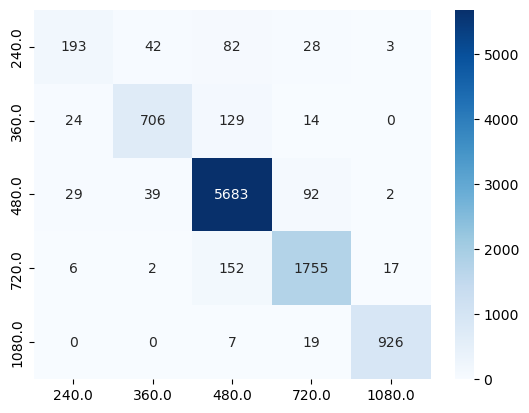

ROC AUC (Macro OVR): 0.984501537467976


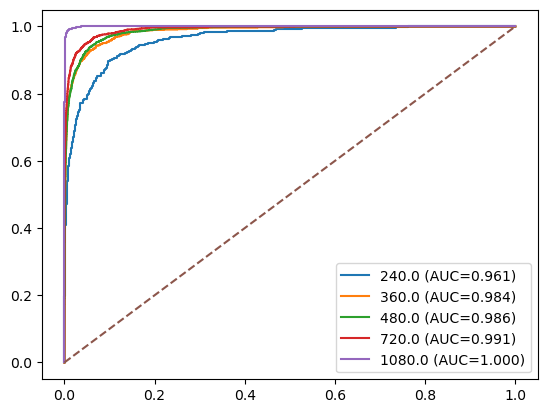

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (Macro):", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

classes = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.show()

y_prob = clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=classes)
print("ROC AUC (Macro OVR):", roc_auc_score(y_test_bin, y_prob, multi_class="ovr", average="macro"))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.3f})")

plt.plot([0, 1], [0, 1], '--')
plt.legend()
plt.show()


## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

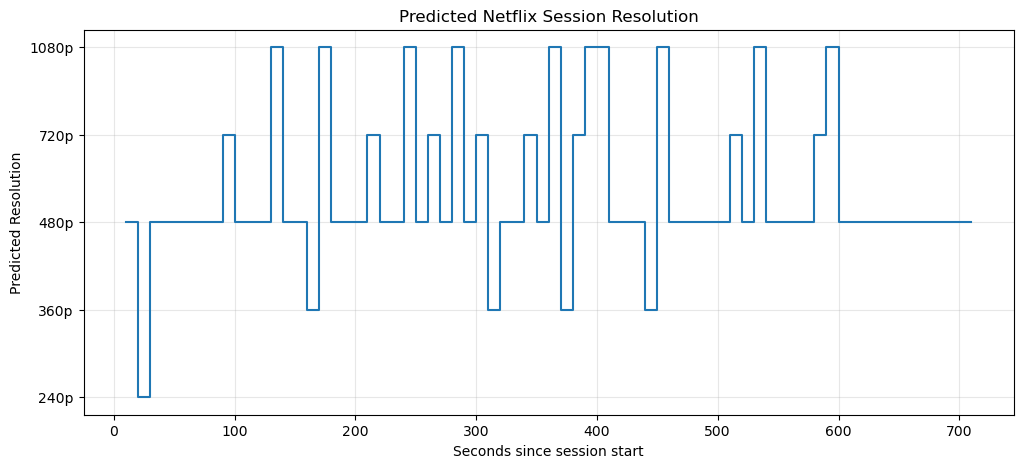

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_hat = clf.predict(X_test)

test_df = pd.DataFrame({
    "t": timestamp_test,
    "y_hat": y_hat
}).sort_values("t")

BIN_SECS = 10
test_df["bin"] = (test_df["t"] // BIN_SECS).astype(int)
binned = test_df.groupby("bin", as_index=False).first()[["bin", "y_hat"]]

RES_ORDER = [240, 360, 480, 720, 1080]
binned["res_level"] = binned["y_hat"].map({r:i for i,r in enumerate(RES_ORDER)})
binned = binned.dropna().reset_index(drop=True)

rel_time = binned["bin"] * BIN_SECS

plt.figure(figsize=(12,5))
plt.step(rel_time, binned["res_level"], where="post")
plt.yticks(range(len(RES_ORDER)), [f"{r}p" for r in RES_ORDER])
plt.xlabel("Seconds since session start")
plt.ylabel("Predicted Resolution")
plt.title("Predicted Netflix Session Resolution")
plt.grid(True, alpha=0.3)
plt.show()
